# Einsums in the wild

In [180]:
import jax
import numpy
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [ ]:
%config InlineBackend.figure_format = "retina"

## The basics

$$
    x^T A x = \sum_{i,j} x_i A_{i,j} x_j
$$

So that we can write `n,nm,m->` to mention that we are summing over all values

In [166]:
mean_vec.T @ prec_matrix @ mean_vec

DeviceArray(64.05614, dtype=float32)

In [167]:
jnp.einsum("i,ij,j->", mean_vec, prec_matrix, mean_vec)

DeviceArray(64.05614, dtype=float32)

If we were to have $N$ such observations, we usually store it a matrix ${\bf X} \in \mathbb{R}^{N\times M}$. So that if we wanted to compute for every row $n$, ${\bf x}_n^T A {\bf x}_n$ the operation $X^T A X$ would not work. We could, however, compute the following

In [168]:
jnp.diag(X @ prec_matrix @ X.T)

DeviceArray([62.88306 , 63.032433, 95.89317 , 66.25706 , 74.08174 ,
             49.777843, 67.0068  , 53.67578 , 98.76991 , 76.38692 ],            dtype=float32)

If we use einsums, to compute $\forall n. {\bf x}_n^T {\bf A} {\bf x}_n$ all we need is to add an additional index to our einsum to express a *constant* dimension: `ni,ij,nj->n`.

We went from `i,ij,j->` to `ni,ij,nj->n`. This is an important remark using einsums: having an *atomic* expression in einsum form is easy to generalise for multiple dimensions. This is not usually the case in vector-matrix form.

In [169]:
key = jax.random.PRNGKey(seed)
N = 10
X = jax.random.multivariate_normal(key, mean_vec, jnp.linalg.inv(prec_matrix), shape=(N,))

jnp.einsum("ni,ij,nj->n", X, prec_matrix, X)

DeviceArray([62.88306 , 63.032433, 95.89317 , 66.25706 , 74.08173 ,
             49.77784 , 67.0068  , 53.67578 , 98.76991 , 76.38692 ],            dtype=float32)

In [170]:
# permutation invariant: product is commutative
jnp.einsum("ni,nj,ij->n", X, X, prec_matrix)

DeviceArray([62.883057, 63.032433, 95.89317 , 66.25706 , 74.08173 ,
             49.77784 , 67.0068  , 53.675785, 98.76991 , 76.386925],            dtype=float32)

In [171]:
# permutation invariant: product is commutative
jnp.einsum("ij,ni,nj->n", prec_matrix, X, X)

DeviceArray([62.88306 , 63.032433, 95.89317 , 66.25706 , 74.08173 ,
             49.77784 , 67.0068  , 53.67578 , 98.76991 , 76.38692 ],            dtype=float32)

### Going deeper

* `i,ij,j->`: scalar output
* `ni,ij,nj->n`: 1-dimensional output
* `nmi,ij,nmj->nm`: 2-dimensional output
* `nmli,ij,nmlj->nml`: 3-dimensional output
* `...i,ij,...j->...`: n-dimensional output

In [176]:
N1, N2, N3, N4 = 2, 4, 2, 3

X_dense = jax.random.multivariate_normal(key, mean_vec, jnp.linalg.inv(prec_matrix), shape=(N1, N2, N3, N4,))
jnp.einsum("...i,ij,...j->...", X_dense, prec_matrix, X_dense)

DeviceArray([[[[ 41.09114 ,  59.0838  ,  56.379395],
               [ 92.74828 ,  60.757946,  82.77587 ]],

              [[ 63.71371 ,  68.96262 ,  68.319275],
               [ 60.699207, 105.16825 ,  41.955074]],

              [[ 53.59115 ,  43.516457,  71.42653 ],
               [ 84.83834 ,  62.787907,  40.053375]],

              [[ 45.064953,  50.189003,  56.48477 ],
               [ 76.87942 ,  66.928345,  52.102295]]],


             [[[ 87.65294 ,  70.58796 ,  70.2894  ],
               [ 46.83759 ,  45.5425  ,  61.541145]],

              [[ 74.07434 ,  76.711075,  48.8777  ],
               [ 58.12687 ,  82.62518 ,  70.20161 ]],

              [[ 60.24123 ,  61.01987 ,  97.484184],
               [ 69.26644 ,  59.18189 ,  85.398186]],

              [[ 68.46581 ,  90.37932 ,  82.5315  ],
               [ 69.817566,  67.56007 ,  97.31043 ]]]], dtype=float32)

# Log-density of a normal distribution

Let  $x\sim\mathcal{N}(\mu, \Sigma)$, then the log-density of $x$ is given by

$$
    \log p({\bf x} \vert \boldsymbol\mu, \Sigma) = -\frac{1}{2}({\bf x} - \boldsymbol\mu)^T\Sigma^{-1}({\bf x} - \boldsymbol\mu) + \text{cst.}
$$

Suppose we want to plot the log-density of a Gaussian distribution up to a constant. As we have previously seen, the expression $x^T A x$ can be represented in einsum form as `i,ij,j->`. A common way to plot this joint-density for a 2-dimensional gaussian is obtain a tuple (x,y) of elements in a grid. This is commonly done using `np.mgrid`.

In [189]:
mean_vec = jnp.array([4.29669692, 1.6520908]) 
prec_matrix = jnp.array([[2.74809243, 0.76832627], [0.76832627, 0.88442754]])

xmin, xmax = -8, 8
ymin, ymax = -10, 10
X_grid = jnp.mgrid[xmin:xmax:step, ymin:ymax:step] + mean_vec[:, None, None]
X_grid.shape

(2, 160, 200)

The variable `X_grid` defined above has three dimensions: `i,n,m`. We let `i` be the dimension corresponding to the elements in the xy-plane given by `n` and `m` respectively. Plotting the log-density is just a matter of using an expression we've already seen:

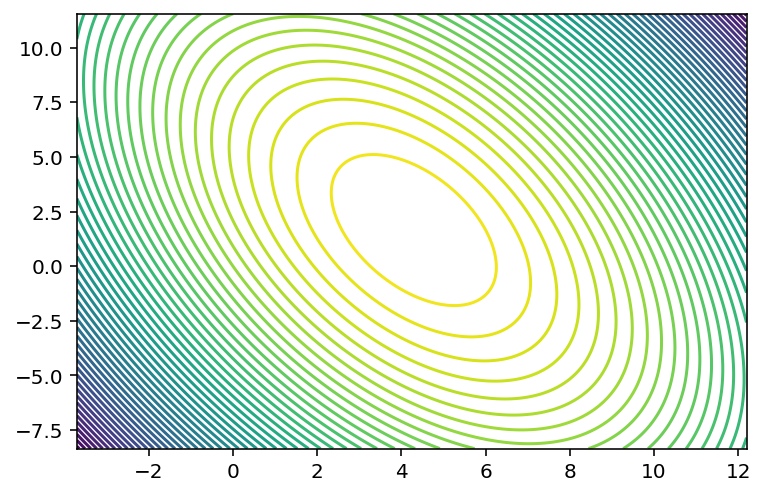

In [196]:
diff_grid = (X_grid - mean_vec[:, None, None])
log_prob_grid = -jnp.einsum("inm,ij,jnm->nm", diff_grid, prec_matrix, diff_grid) / 2
plt.contour(*X_grid, log_prob_grid, 50)

## Predictive surface of a logistic regression

As long as the inner-most operation we want to compute consists of a linear combination of elements, we can make use of einsums. As a second example, consider the estimation of the predictive surface of a logistic regression with Gaussian prior. That is, we want to compute

$$
\begin{aligned}
    p(\hat y = 1 \vert {\bf x}) &= \int_{\mathbb{R}^2} \sigma({\bf w}^T {\bf x}) p({\bf w} \vert \mathcal{D}) d{\bf w}\\ 
  &= \mathbb{E}_{{\bf w} \vert \mathcal{D}}\big[\sigma({\bf w}^T {\bf x})\big]\\
  &\approx \frac{1}{S} \sum_{s=1}^S \sigma\left({\bf w^{(s)}}^T {\bf x}\right)
\end{aligned}
$$

Suppose we've already estimated the posterior parameters $\hat{\bf w}, \hat\Sigma$.